<span style='font-size:xx-large'>**Lending Club Case Study**</span>


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.3)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

<span style='font-size:x-large'>**Reading the data set**</span>


In [2]:
OriginDataSet = pd.read_csv('loan.csv',header=0,
                            low_memory=False)
OriginDataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


<span style='font-size:x-large'>**Sanitization**</span>


In [3]:

#getting the types of the columns and the structure of the whole dataset and removing the all NaN columns and rows
#cleaning simply all Null columns and rows which are not usefull
OriginDataSet = OriginDataSet.dropna(axis = 0, how = 'all')
OriginDataSet = OriginDataSet.dropna(axis = 1, how = 'all')
OriginDataSet.info()
#remove columns that have only 1 feature
#get unique values per feature
nunique_value = OriginDataSet.apply(pd.Series.nunique)
#note columns that have single value
single_value_cols = nunique_value[nunique_value == 1].index.tolist()
print(single_value_cols)
# drop the redundant columns
OriginDataSet = OriginDataSet.drop(columns=single_value_cols)
OriginDataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39717 non-null  int64  
 1   member_id                   39717 non-null  int64  
 2   loan_amnt                   39717 non-null  int64  
 3   funded_amnt                 39717 non-null  int64  
 4   funded_amnt_inv             39717 non-null  float64
 5   term                        39717 non-null  object 
 6   int_rate                    39717 non-null  object 
 7   installment                 39717 non-null  float64
 8   grade                       39717 non-null  object 
 9   sub_grade                   39717 non-null  object 
 10  emp_title                   37258 non-null  object 
 11  emp_length                  38642 non-null  object 
 12  home_ownership              39717 non-null  object 
 13  annual_inc                  397

In [4]:

# Dropping Columns based on missing data being more than 90%
a=OriginDataSet.isnull().sum()/len(OriginDataSet)*100
variables = OriginDataSet.columns
variable = [ ]
for i in range(0,len(OriginDataSet.columns)):
    if a[i]<50:
        variable.append(variables[i])
drop_columns1=list(set(variables) - set(variable))
print(drop_columns1)
OriginDataSet=OriginDataSet.drop(columns=drop_columns1)
OriginDataSet.info()

id                          0.000000
member_id                   0.000000
loan_amnt                   0.000000
funded_amnt                 0.000000
funded_amnt_inv             0.000000
term                        0.000000
int_rate                    0.000000
installment                 0.000000
grade                       0.000000
sub_grade                   0.000000
emp_title                   6.191303
emp_length                  2.706650
home_ownership              0.000000
annual_inc                  0.000000
verification_status         0.000000
issue_d                     0.000000
loan_status                 0.000000
url                         0.000000
desc                       32.580507
purpose                     0.000000
title                       0.027696
zip_code                    0.000000
addr_state                  0.000000
dti                         0.000000
delinq_2yrs                 0.000000
earliest_cr_line            0.000000
inq_last_6mths              0.000000
m

In [5]:

OriginDataSet['pub_rec_bankruptcies'] = np.where(OriginDataSet['pub_rec_bankruptcies']>0, 1, 0)

# pub_rec
OriginDataSet['pub_rec'] = np.where(OriginDataSet['pub_rec']>0, 1, 0)

### instantiate dicts ### 
term_to_int = {' 36 months': 1,' 60 months': 2}
grade_to_int = dict(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G'], np.arange(7, 0, -1)))

#copied from above, we can write a function to generate this dict
sub_grade_sorted = {'G5': 0, 'G4': 1, 'G3': 2, 'G2': 3, 'G1': 4,
                        'F5': 5, 'F4': 6, 'F3': 7, 'F2': 8, 'F1': 9,
                        'E5': 10, 'E4': 11, 'E3': 12, 'E2': 13, 'E1': 14,
                        'D5': 15, 'D4': 16, 'D3': 17, 'D2': 18, 'D1': 19,
                        'C5': 20, 'C4': 21, 'C3': 22, 'C2': 23, 'C1': 24,
                        'B5': 25, 'B4': 26, 'B3': 27, 'B2': 28, 'B1': 29,
                        'A5': 30, 'A4': 31, 'A3': 32, 'A2': 33, 'A1': 34}
home_to_int = {'OWN': 5,'MORTGAGE': 4, 'RENT': 3,'ANY': 2,'OTHER': 1, 'NONE':0 }
ver_stat_to_int = {'Source Verified':2,'Verified': 1,'Not Verified': 0}

#the date column to be converted numeric
def convert_Date_to_Month(str_d):
    if len(str_d) == 6:
        return str_d[3:]
    elif len(str_d) == 5:
        return str_d[2:]
    else:
        return '0'
OriginDataSet['issue_d'] = OriginDataSet['issue_d'].apply(convert_Date_to_Month)

# Mapping the months
month_map = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5,
                        'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10,
                        'Nov': 11, 'Dec': 12}

#replacements of above dictionaries
OriginDataSet.replace({'term': term_to_int, 'grade':grade_to_int,'sub_grade': sub_grade_sorted,'home_ownership':home_to_int,'verification_status':ver_stat_to_int,'issue_d':month_map}, inplace=True)

#fix zip codes and keep first 3
OriginDataSet['zip_len_3'] = OriginDataSet['zip_code'].str.replace('x','')
OriginDataSet['zip_len_2'] = OriginDataSet['zip_len_3'].str[:2]

#mapping the loan status to numerical values
OriginDataSet['loan_status_bit'] = OriginDataSet['loan_status'].map({'Fully Paid': 0,'Charged Off': 1,'Current':2})

#drop nans in case we missed any
OriginDataSet = OriginDataSet.dropna(axis=0)
OriginDataSet.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,grade,sub_grade,home_ownership,...,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies,loan_status_bit
count,2.505900e+04,2.505900e+04,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000,...,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000
mean,6.464370e+05,8.010991e+05,11592.413903,11290.586217,10540.867191,1.261862,336.049379,5.405643,23.951594,3.576001,...,12544.114267,11746.737133,10117.339993,2329.787251,1.456609,95.530520,13.093321,2744.140177,0.040105,0.191508
std,2.167382e+05,2.788506e+05,7335.279993,7065.411430,7065.627946,0.439657,206.172555,1.383714,6.763175,0.639322,...,8940.723952,8894.725086,6976.447969,2598.290338,7.625584,682.468026,150.825938,4442.048131,0.196210,0.457201
min,5.574200e+04,7.367300e+04,500.000000,500.000000,0.000000,1.000000,16.080000,1.000000,0.000000,0.000000,...,33.730000,0.000000,0.000000,6.220000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000
25%,4.739450e+05,5.982635e+05,6000.000000,6000.000000,5000.000000,1.000000,180.390000,5.000000,20.000000,3.000000,...,5905.854192,5316.045000,5000.000000,719.795000,0.000000,0.000000,0.000000,232.430000,0.000000,0.000000
50%,6.201500e+05,7.940490e+05,10000.000000,10000.000000,9243.350816,1.000000,298.800000,6.000000,25.000000,4.000000,...,10501.021700,9624.340000,8773.990000,1438.340000,0.000000,0.000000,0.000000,576.400000,0.000000,0.000000
75%,8.108065e+05,1.017200e+06,15000.000000,15000.000000,14575.090570,2.000000,448.615000,6.000000,29.000000,4.000000,...,16984.449590,16091.255000,14000.000000,2926.155000,0.000000,0.000000,0.000000,3484.970000,0.000000,0.000000
max,1.077430e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,2.000000,1288.100000,7.000000,34.000000,5.000000,...,58563.679930,58563.680000,35000.020000,23563.680000,166.429711,22943.370000,6543.040000,35479.890000,1.000000,2.000000


In [6]:
def convert_emp_to_num(str_d):
    if pd.isna(str_d):
        return None
    elif str_d[2]=='+':
        return 10
    elif str_d[0]=='<':
        return 0
    else:
        return int(str_d[0])

OriginDataSet['emp_length_num'] = OriginDataSet['emp_length'].apply(convert_emp_to_num)
OriginDataSet['emp_length_num'].head()

1     0
3    10
4     1
6     8
7     9
Name: emp_length_num, dtype: int64

In [7]:
# Deleting the columns that are not relavent which are post loan related columns
un_wanted_cols = ['id','delinq_2yrs',
'earliest_cr_line',
'inq_last_6mths',
'open_acc',
'pub_rec',
'revol_bal',
'revol_util',
'total_acc',
'out_prncp',
'out_prncp_inv',
'total_pymnt',
'total_pymnt_inv',
'total_rec_prncp',
'total_rec_int',
'total_rec_late_fee',
'recoveries',
'collection_recovery_fee',
'last_pymnt_d',
'last_pymnt_amnt',
'last_credit_pull_d']
OriginDataSet=OriginDataSet.drop(columns=un_wanted_cols)
OriginDataSet.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,dti,pub_rec_bankruptcies,loan_status_bit,emp_length_num
count,2.505900e+04,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000,2.505900e+04,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000,25059.000000
mean,8.010991e+05,11592.413903,11290.586217,10540.867191,1.261862,336.049379,5.405643,23.951594,3.576001,6.933609e+04,0.785267,7.057704,13.408504,0.040105,0.191508,4.873339
std,2.788506e+05,7335.279993,7065.411430,7065.627946,0.439657,206.172555,1.383714,6.763175,0.639322,5.888417e+04,0.794604,3.426716,6.643081,0.196210,0.457201,3.544704
min,7.367300e+04,500.000000,500.000000,0.000000,1.000000,16.080000,1.000000,0.000000,0.000000,4.000000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,5.982635e+05,6000.000000,6000.000000,5000.000000,1.000000,180.390000,5.000000,20.000000,3.000000,4.200000e+04,0.000000,4.000000,8.340000,0.000000,0.000000,2.000000
50%,7.940490e+05,10000.000000,10000.000000,9243.350816,1.000000,298.800000,6.000000,25.000000,4.000000,6.000000e+04,1.000000,7.000000,13.540000,0.000000,0.000000,4.000000
75%,1.017200e+06,15000.000000,15000.000000,14575.090570,2.000000,448.615000,6.000000,29.000000,4.000000,8.300000e+04,1.000000,10.000000,18.660000,0.000000,0.000000,9.000000
max,1.314167e+06,35000.000000,35000.000000,35000.000000,2.000000,1288.100000,7.000000,34.000000,5.000000,3.900000e+06,2.000000,12.000000,29.990000,1.000000,2.000000,10.000000


In [8]:

#Balance_annual_income calculations and logging the annual income feaure for ease of calculations
OriginDataSet['balance_annual_inc'] = OriginDataSet['loan_amnt'] / OriginDataSet['annual_inc']
OriginDataSet['annual_inc']+=1
OriginDataSet['annual_inc']=np.log(OriginDataSet['annual_inc'])


#finding and indusing the ratio of instalments for further analysis
OriginDataSet['inst_amnt_ratio']=OriginDataSet['installment']/OriginDataSet['loan_amnt']


#Filtering the dataset to have only fully paid and default status records excluding the current category
OriginDataSet = OriginDataSet[OriginDataSet['loan_status_bit'] != 2]

#interest rate feature cleaning
OriginDataSet['int_rate'] = pd.to_numeric(OriginDataSet['int_rate'].str.replace('%',''))

#Dividing the numeric and object columns and selecting the useful columns for analysis
num_cols = OriginDataSet.select_dtypes(exclude='object').columns
print(num_cols)
obj_cols = OriginDataSet.select_dtypes(include='object').columns
print(obj_cols)
num_cols = ['int_rate','loan_amnt', 'funded_amnt','issue_d', 'funded_amnt_inv', 'term',
       'installment', 'grade', 'sub_grade', 'home_ownership', 'annual_inc',
       'verification_status', 'dti', 'loan_status_bit',
       'emp_length_num', 'balance_annual_inc', 'inst_amnt_ratio']
obj_cols = ['purpose','addr_state','zip_len_2']


Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'sub_grade', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'dti',
       'pub_rec_bankruptcies', 'loan_status_bit', 'emp_length_num',
       'balance_annual_inc', 'inst_amnt_ratio'],
      dtype='object')
Index(['emp_title', 'emp_length', 'loan_status', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'zip_len_3', 'zip_len_2'],
      dtype='object')


In [9]:
#displaying numeric columns and objects columns for further selections
OriginDataSet[obj_cols].head()
OriginDataSet[num_cols].head()

,int_rate,loan_amnt,funded_amnt,issue_d,funded_amnt_inv,term,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,dti,loan_status_bit,emp_length_num,balance_annual_inc,inst_amnt_ratio
1,15.27,2500,2500,12,2500.0,2,59.83,5,21,3,10.308986,2,1.00,1,0,0.083333,0.023932
3,13.49,10000,10000,12,10000.0,1,339.31,5,24,3,10.803669,2,20.00,0,10,0.203252,0.033931
6,15.96,7000,7000,12,7000.0,2,170.08,5,20,3,10.758009,0,23.51,0,8,0.148923,0.024297
7,18.64,3000,3000,12,3000.0,1,109.43,3,14,3,10.778977,2,5.35,0,9,0.062500,0.036477
9,12.69,5375,5375,12,5350.0,2,121.45,6,25,3,9.615872,1,18.08,1,0,0.358333,0.022595


<span style='font-size:x-large'>**Data visualization and feature engineering**</span>


<span style='font-size:large'>Analysis of distribution of features</span>



<span style='font-size:large'>Insights of the below plots we have following conclusions </span>

- The trend of Loan ,Funded and invested amount features are identical
- There are huge sum distribution of cases who are have long employment 
- There are huge sum distribution of cases with fully paid loan settlements
- There are huge sum distribution of cases with rented and mortgage houses
- Found incremental trend as the grade and subgrade increases
- There are lot of customers with income not verified
- identified that the average customers are having 16%\-18% DTI ratio where 36% above are termed as high risk of defaulting
- Debt Consolidation and credit related loans are higher in the distribution compared to other features



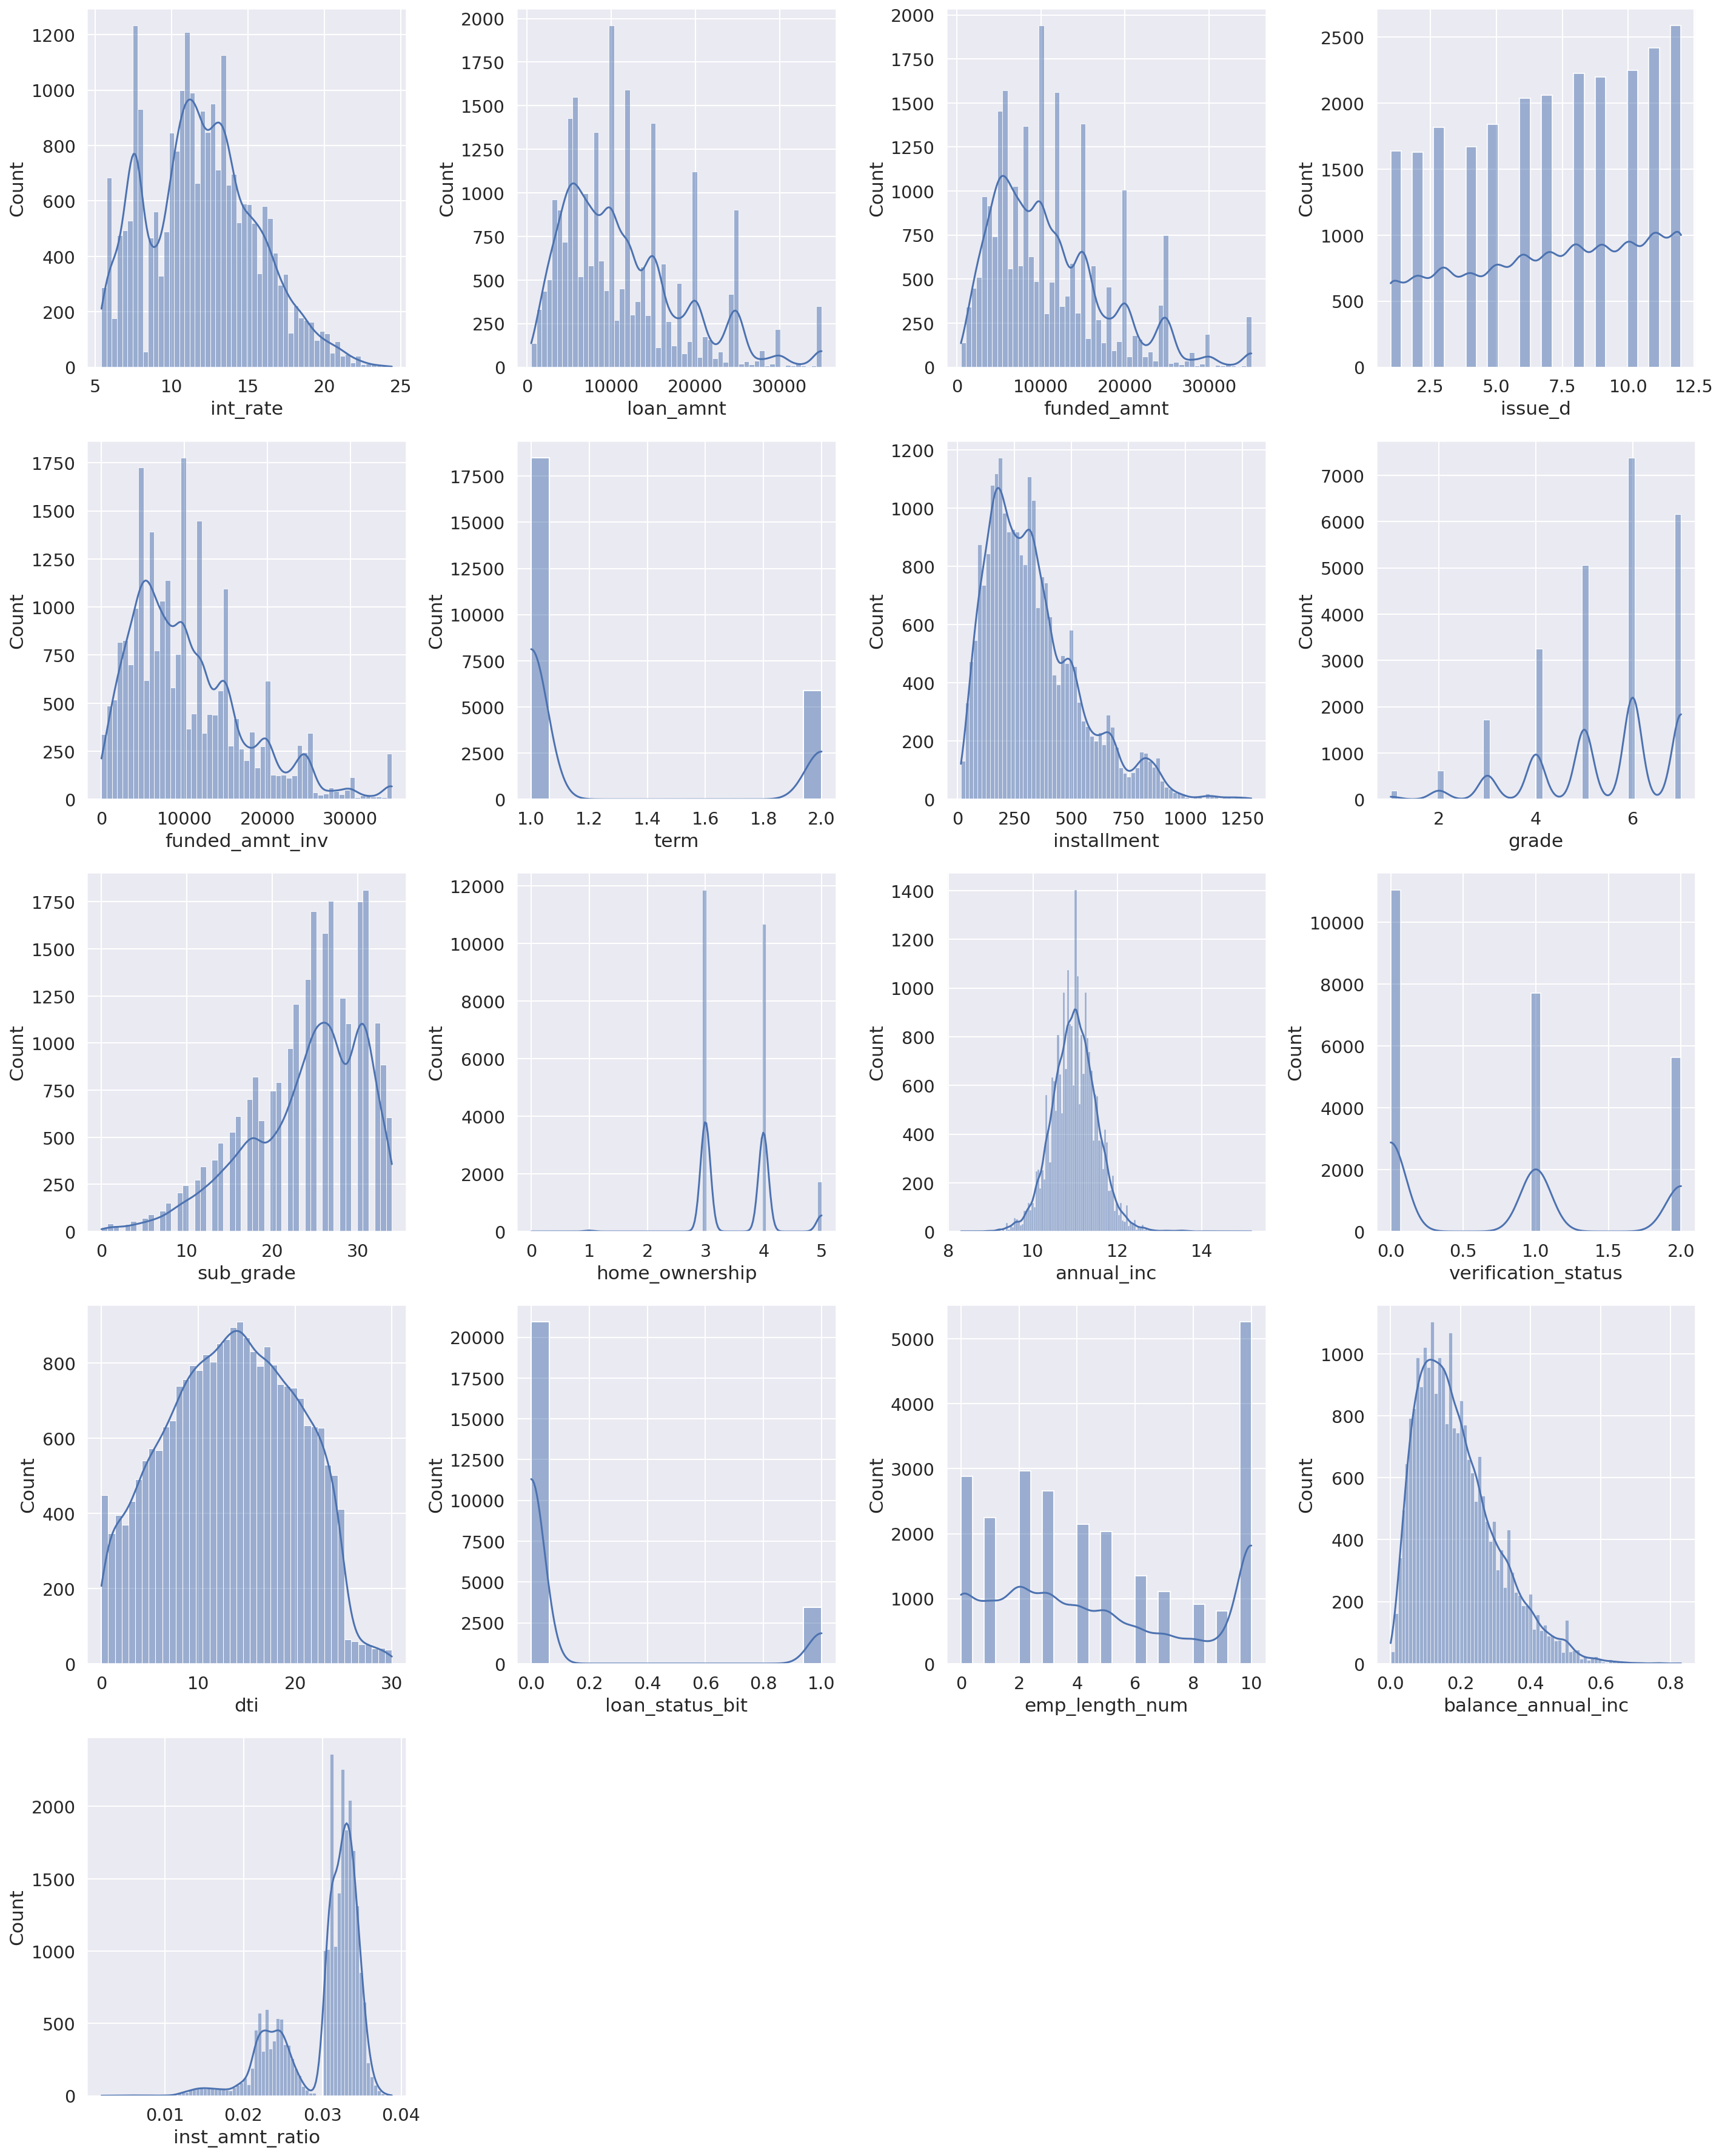

In [10]:
cols = 4
rows = 5
fig = plt.figure( figsize=(cols*5, rows*5))
for i, col in enumerate(num_cols):
    ax=fig.add_subplot(rows,cols,i+1)
    sns.histplot(x = OriginDataSet[col], ax = ax,kde=True)
fig.tight_layout()
plt.show()

<span style='font-size:large'>Analysis of Distribution of categorical features</span>


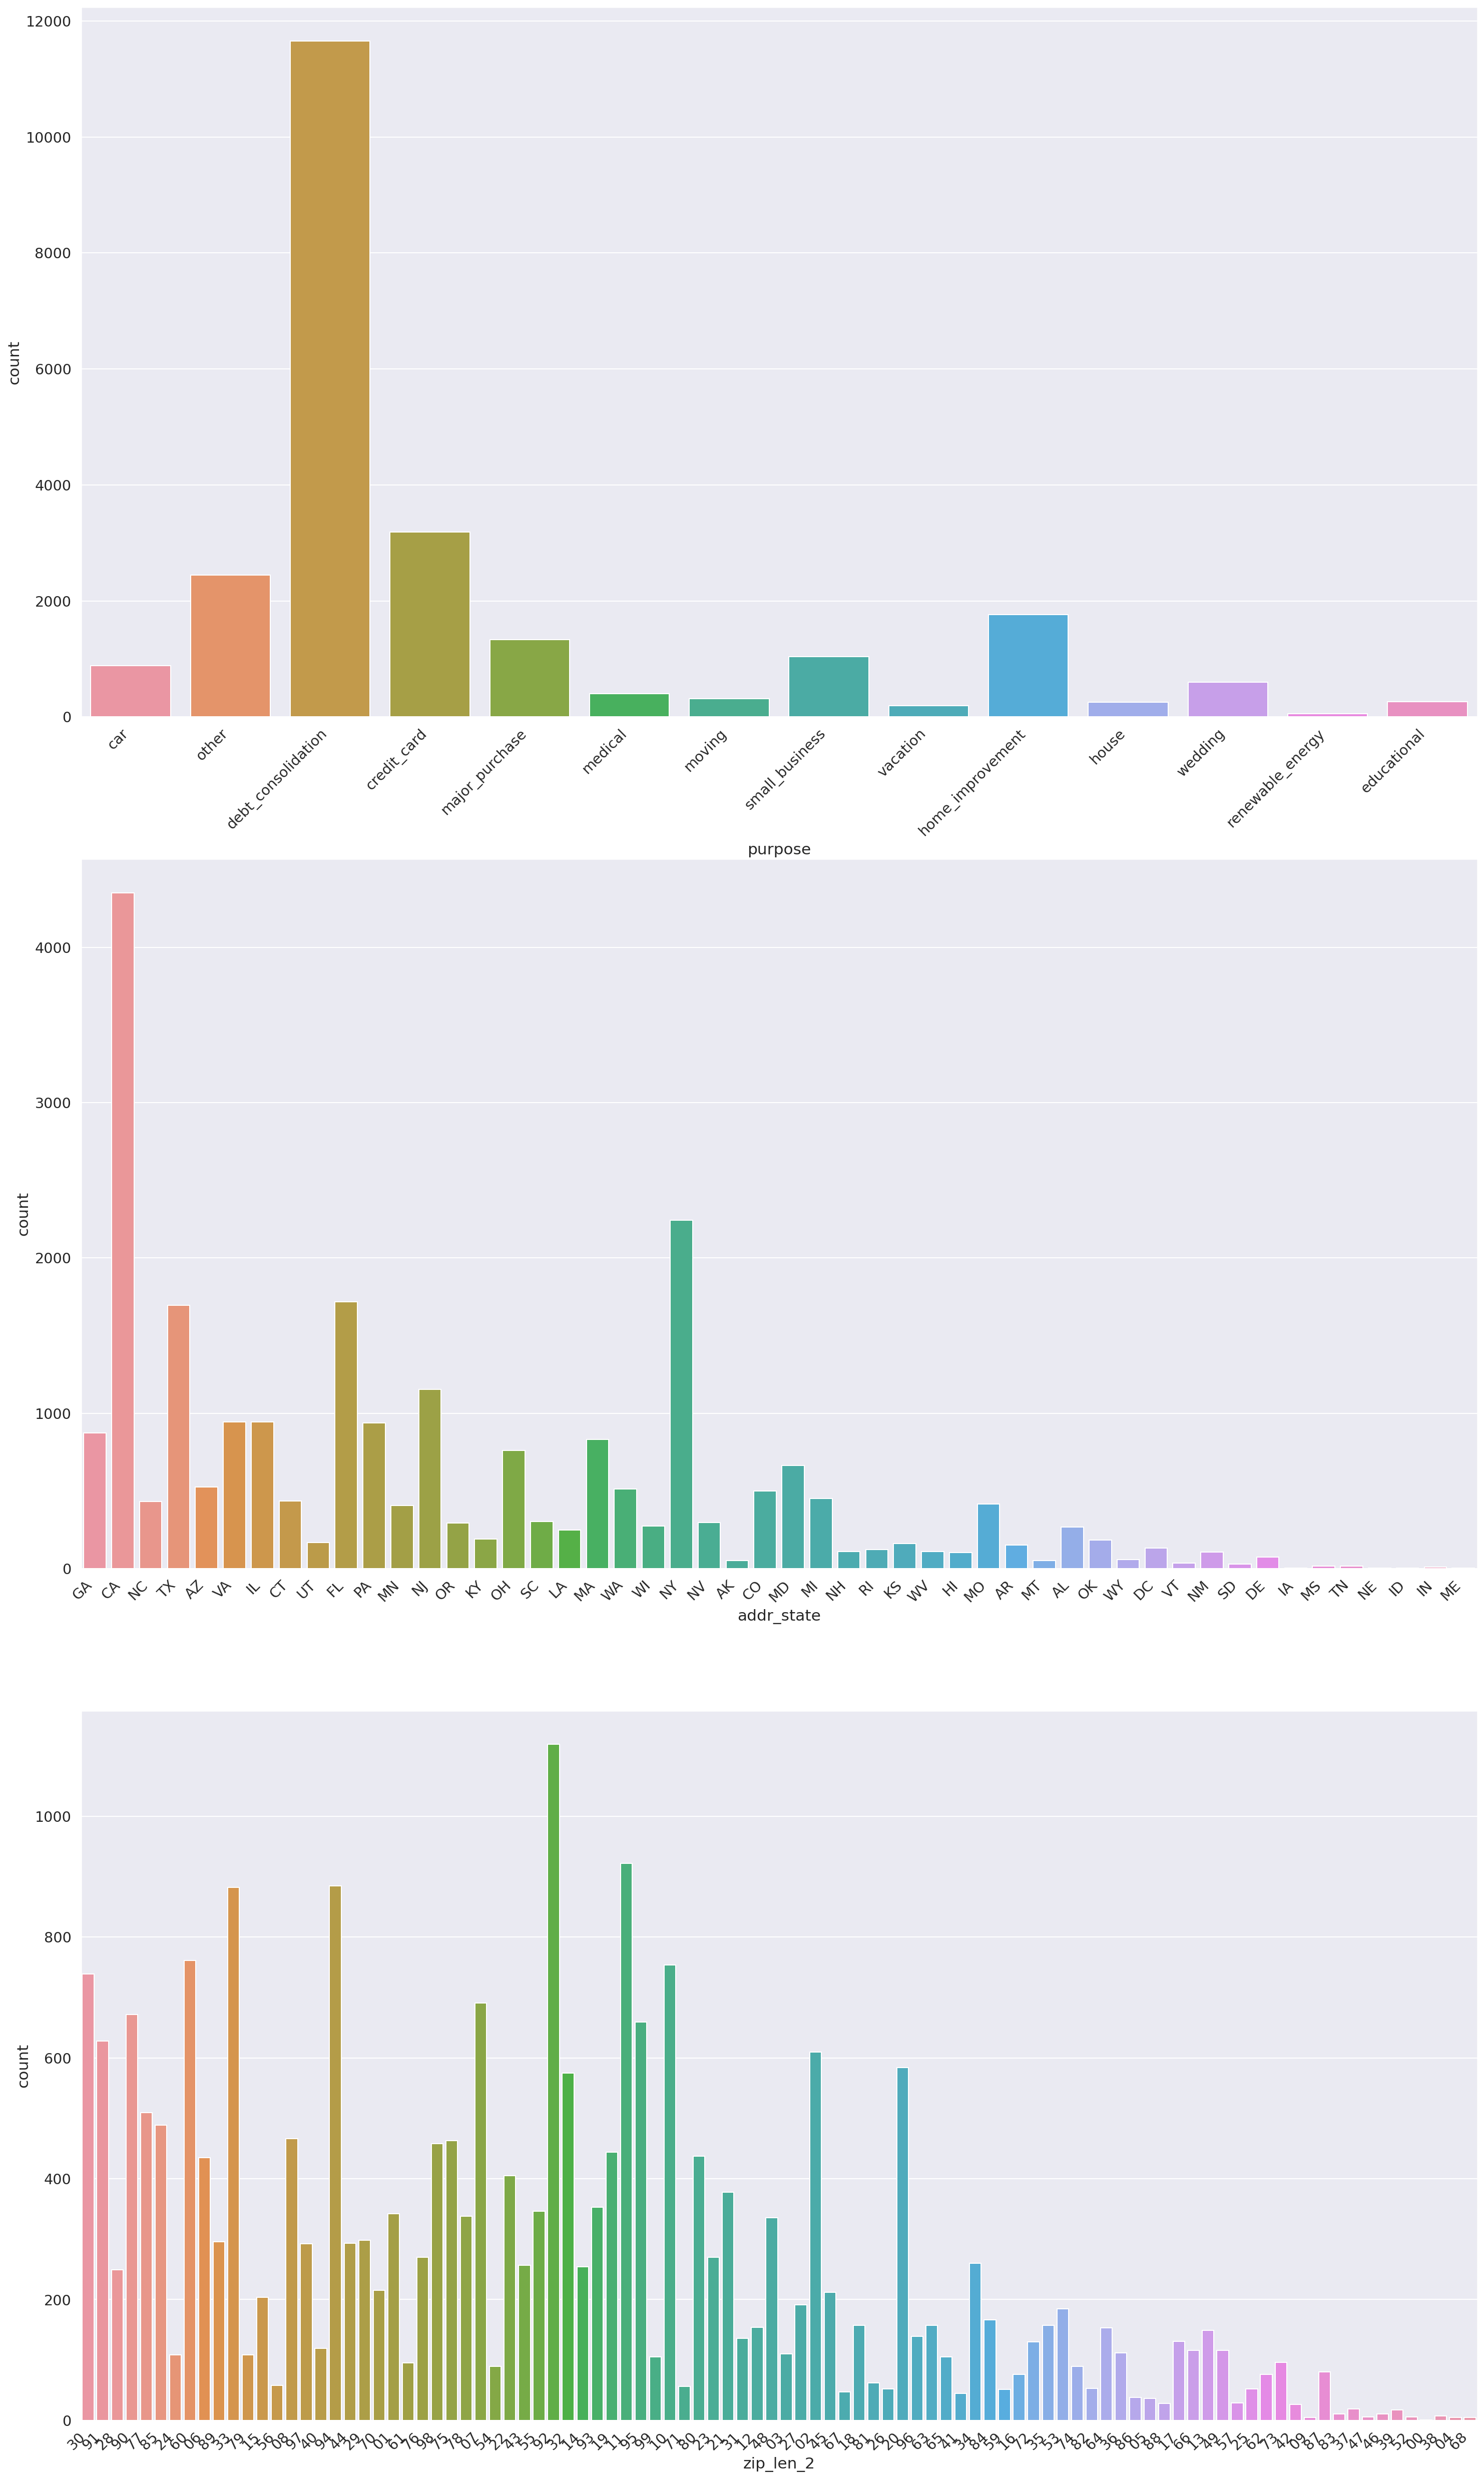

In [11]:
cols = 1
rows = 4
fig = plt.figure(figsize= (cols*25,rows*15))
for i, col in enumerate(obj_cols):
    ax=fig.add_subplot(rows, cols, i+1)
    sns.countplot(x=OriginDataSet[col], ax=ax)
    plt.xticks(rotation=45, ha='right')
plt.show()

<span style='font-size:large'>**Checking for Suspected Outliers Testing**</span>


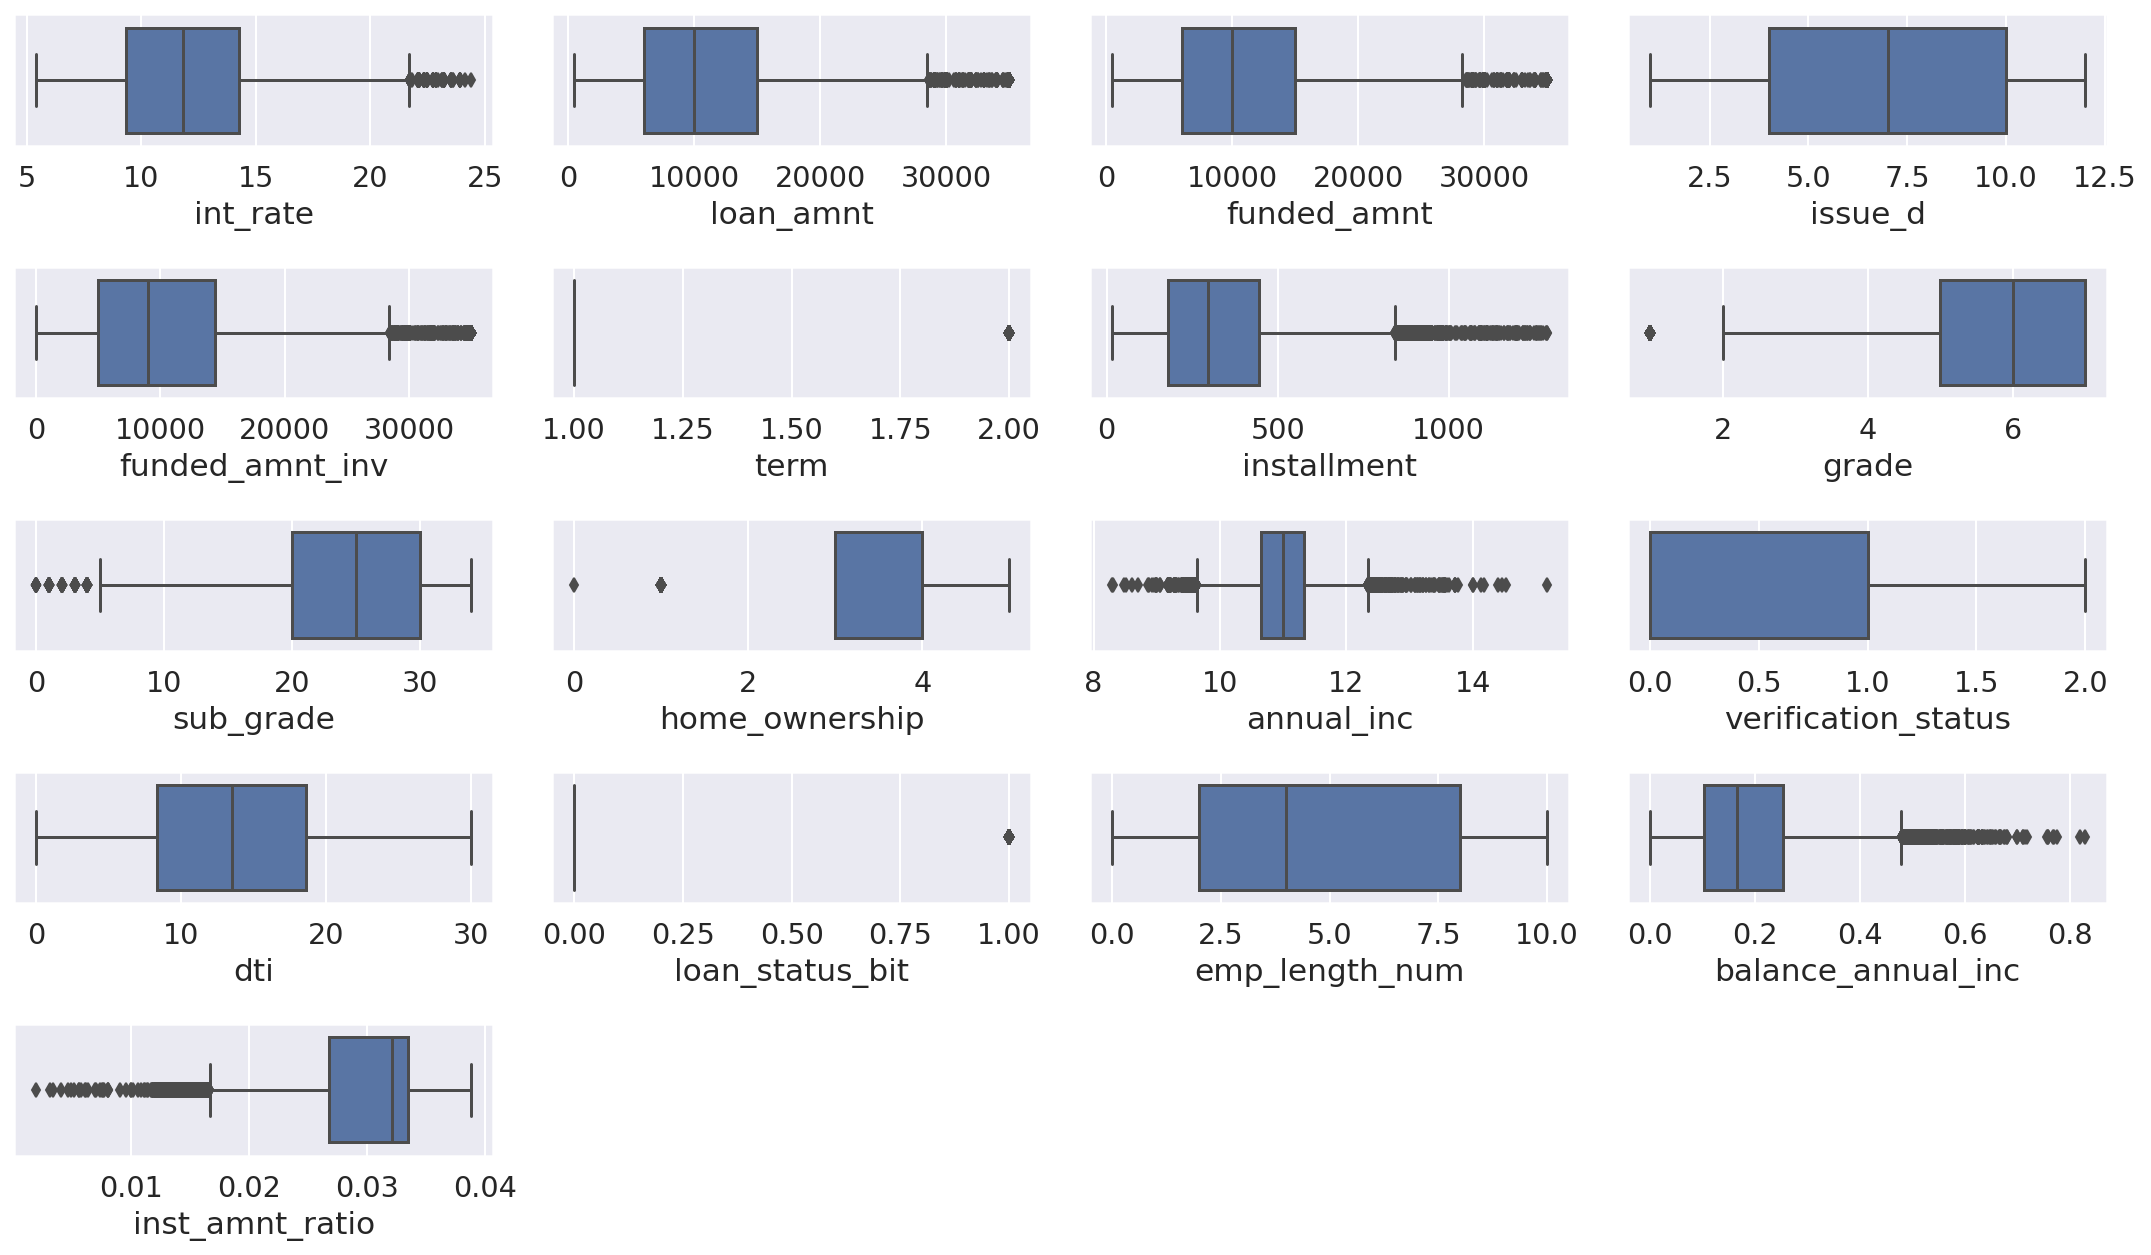

In [12]:
cols = 4
rows = 5
fig = plt.figure(figsize= (15,9))
for i, col in enumerate(num_cols):
    ax=fig.add_subplot( rows, cols, i+1)
    sns.boxplot(x=OriginDataSet[col], ax=ax)
fig.tight_layout()
plt.show()

<span style='font-size:medium'>**Bivariate Analysis & Multivariate Analysis**</span>


Text(0.5, 0, 'loans status')

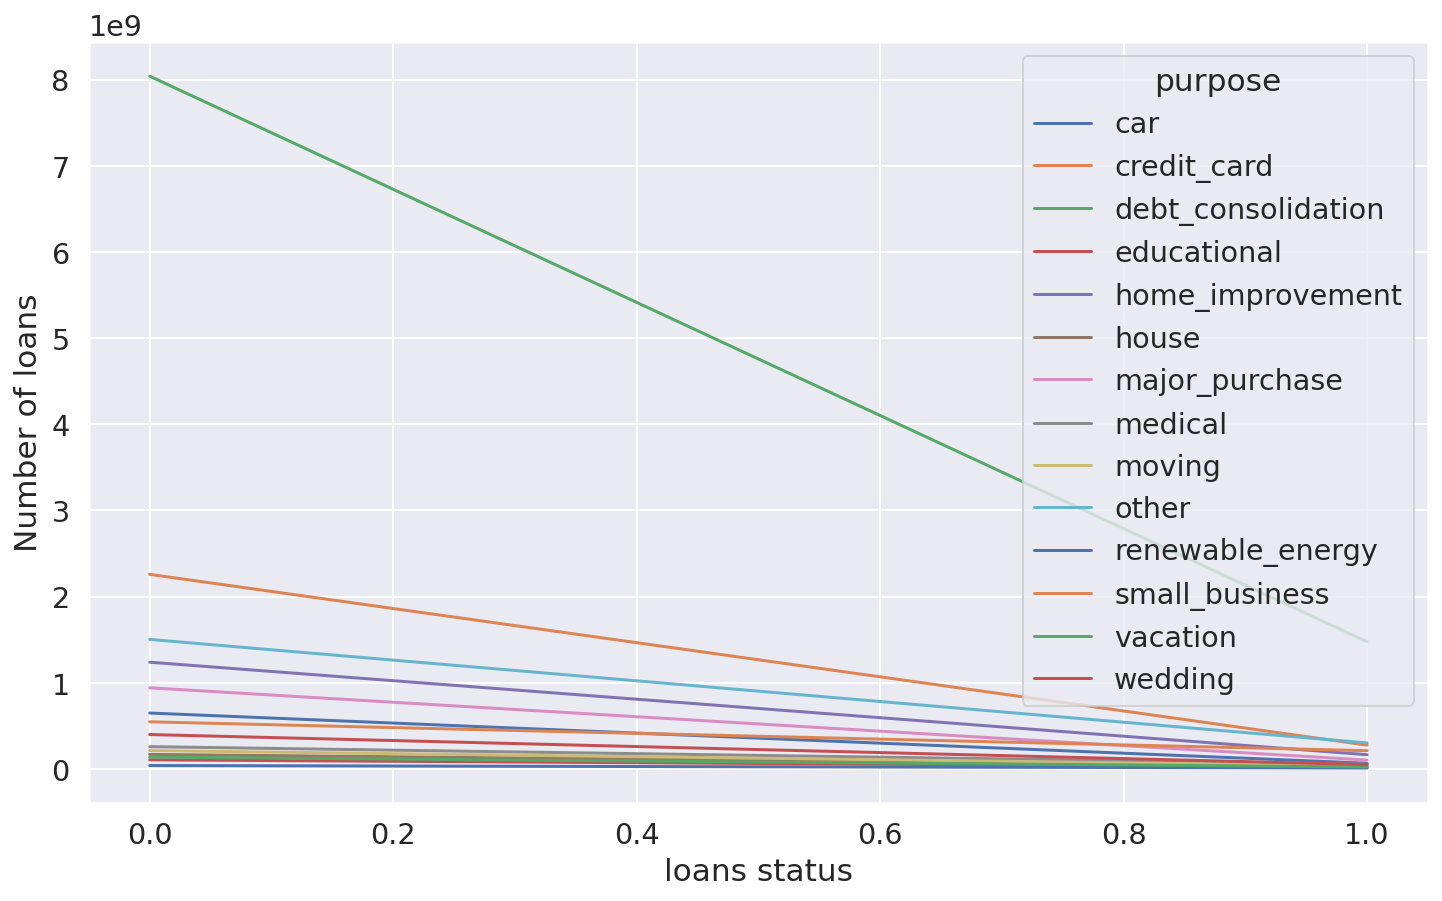

In [13]:
# number of loans distributed over the purpose and Status of the loan
OriginDataSet.pivot_table('member_id',index ='loan_status_bit',columns='purpose',aggfunc='sum').plot()
plt.ylabel('Number of loans')
plt.xlabel('loans status')

Text(0, 0.5, 'balance annual income')

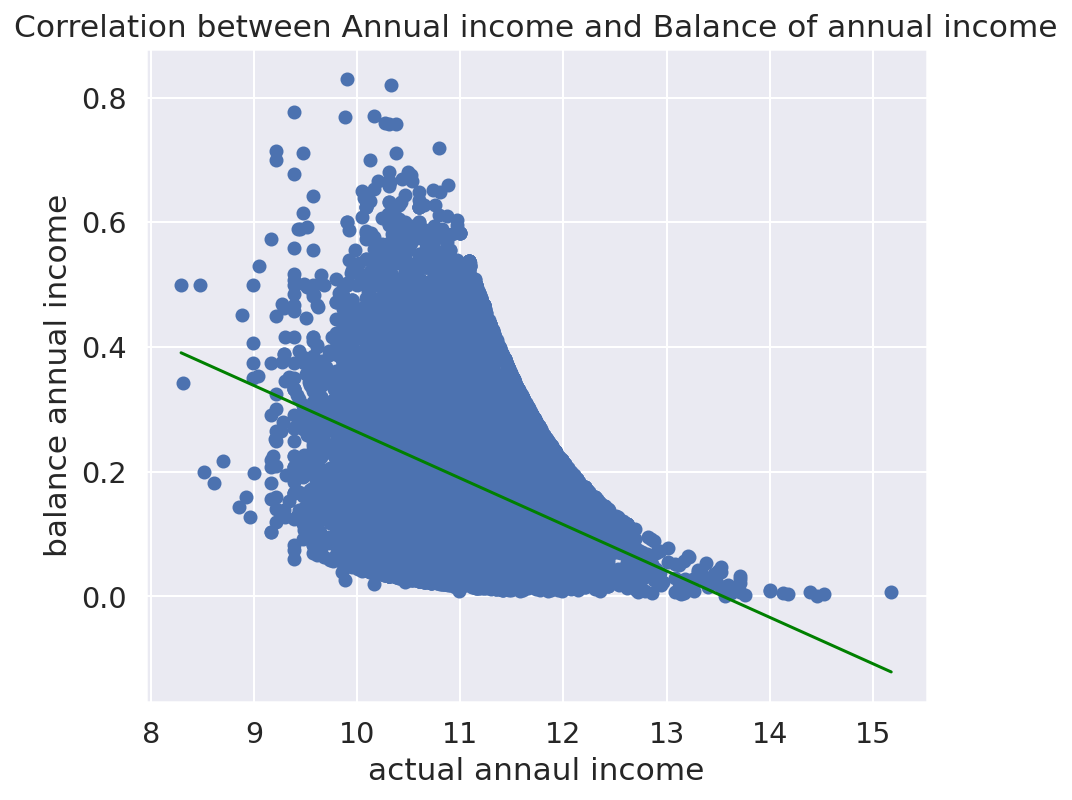

In [14]:
# Plot to identify the balance annual income corelation with actual annaul income
var1 = OriginDataSet['annual_inc']
var2 = OriginDataSet['balance_annual_inc']
fig = plt.figure(figsize= (7,6))
plt.title ('Correlation between Annual income and Balance of annual income')
plt.scatter (var1, var2)
plt.plot (np.unique(var1), np.poly1d(np.polyfit(var1, var2, 1))(np.unique(var1)), color = 'green')
plt.xlabel ('actual annaul income')
plt.ylabel ('balance annual income')


Text(0.5, 0, 'loans status')

<Figure size 504x432 with 0 Axes>

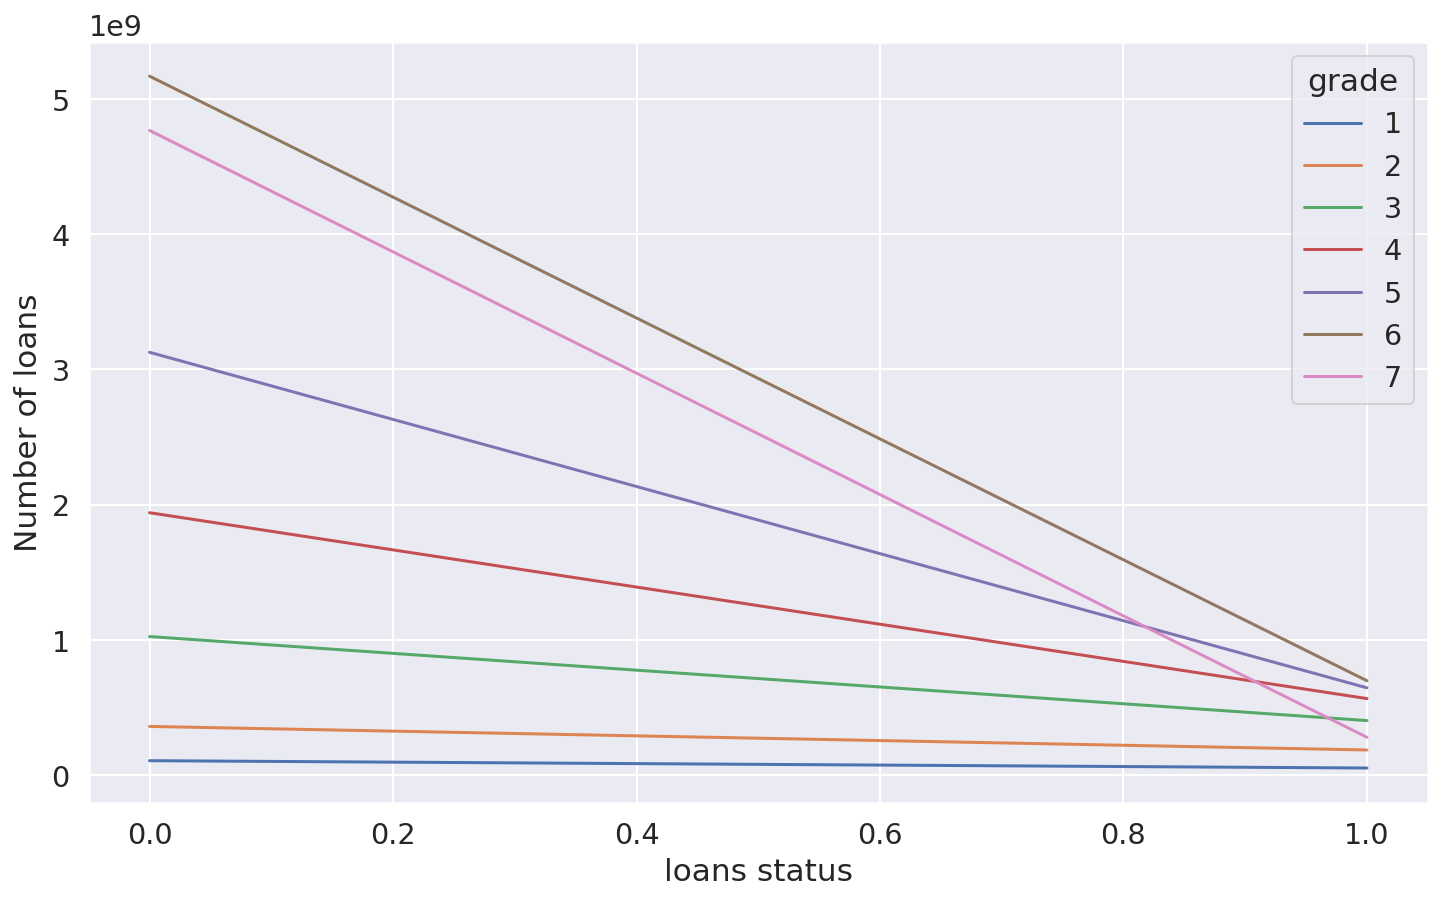

In [15]:
# number of loans distributed over the grade and Status of the loan
fig = plt.figure(figsize= (7,6))
OriginDataSet.pivot_table('member_id',index ='loan_status_bit',columns='grade',aggfunc='sum').plot()
plt.ylabel('Number of loans')
plt.xlabel('loans status')

Text(0, 0.5, 'fundend amount by investors')

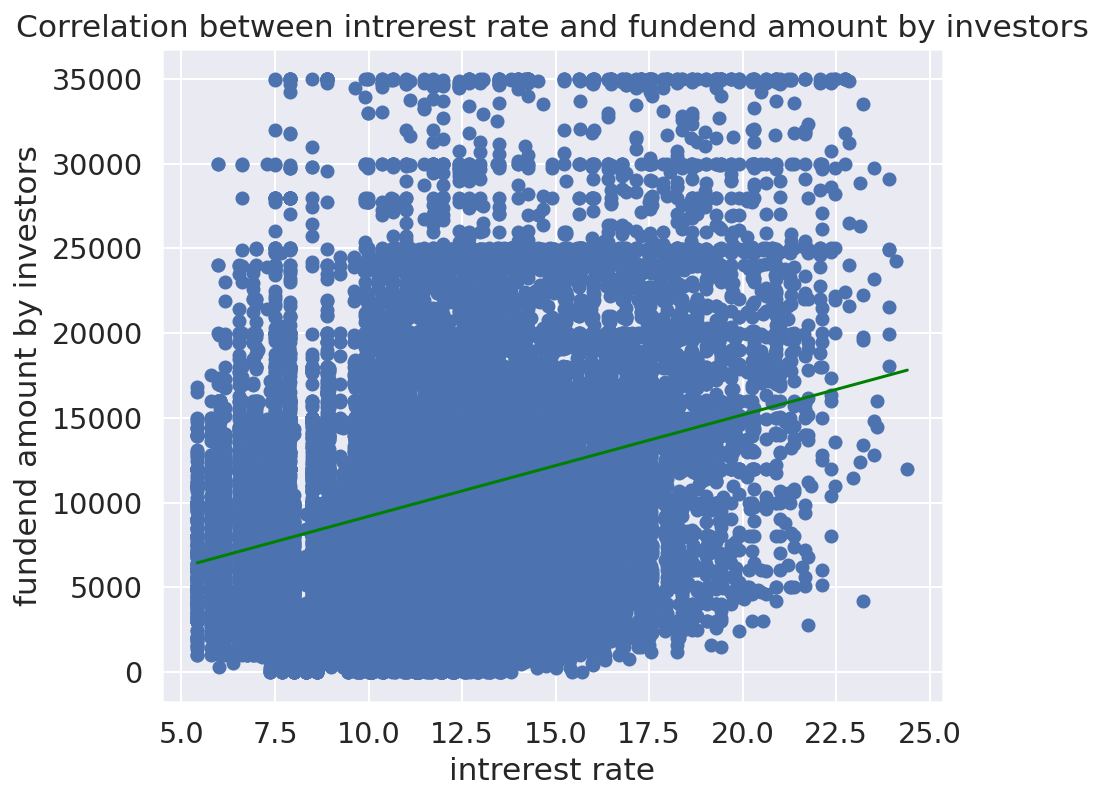

In [16]:
# Plot to identify the interest rate corelation with Investor fund
var1 = OriginDataSet['int_rate']
var2 = OriginDataSet['funded_amnt_inv']
fig = plt.figure(figsize= (7,6))
plt.title ('Correlation between intrerest rate and fundend amount by investors')
plt.scatter (var1, var2)
plt.plot (np.unique(var1), np.poly1d(np.polyfit(var1, var2, 1))(np.unique(var1)), color = 'green')
plt.xlabel ('intrerest rate')
plt.ylabel ('fundend amount by investors')



Text(0, 0.5, 'Loan status')

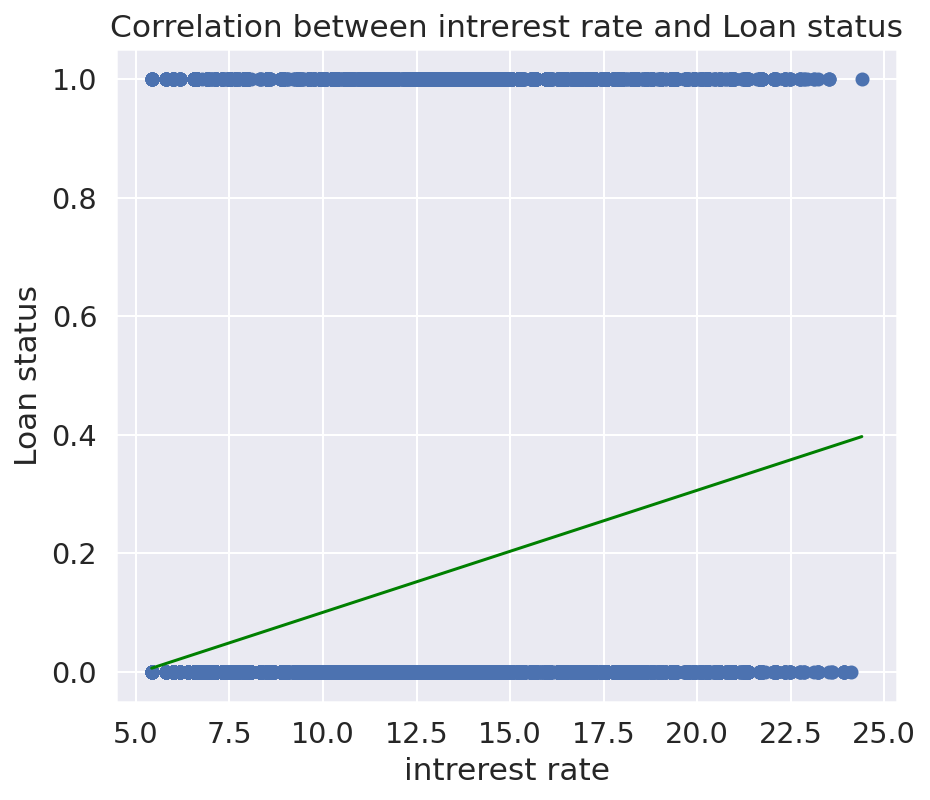

In [17]:
# Plot to identify the interest rate corelation with Loan status
var1 = OriginDataSet['int_rate']
var2 = OriginDataSet['loan_status_bit']
fig = plt.figure(figsize= (7,6))
plt.title ('Correlation between intrerest rate and Loan status')
plt.scatter (var1, var2)
plt.plot (np.unique(var1), np.poly1d(np.polyfit(var1, var2, 1))(np.unique(var1)), color = 'green')
plt.xlabel ('intrerest rate')
plt.ylabel ('Loan status')

Text(0, 0.5, 'Loan status')

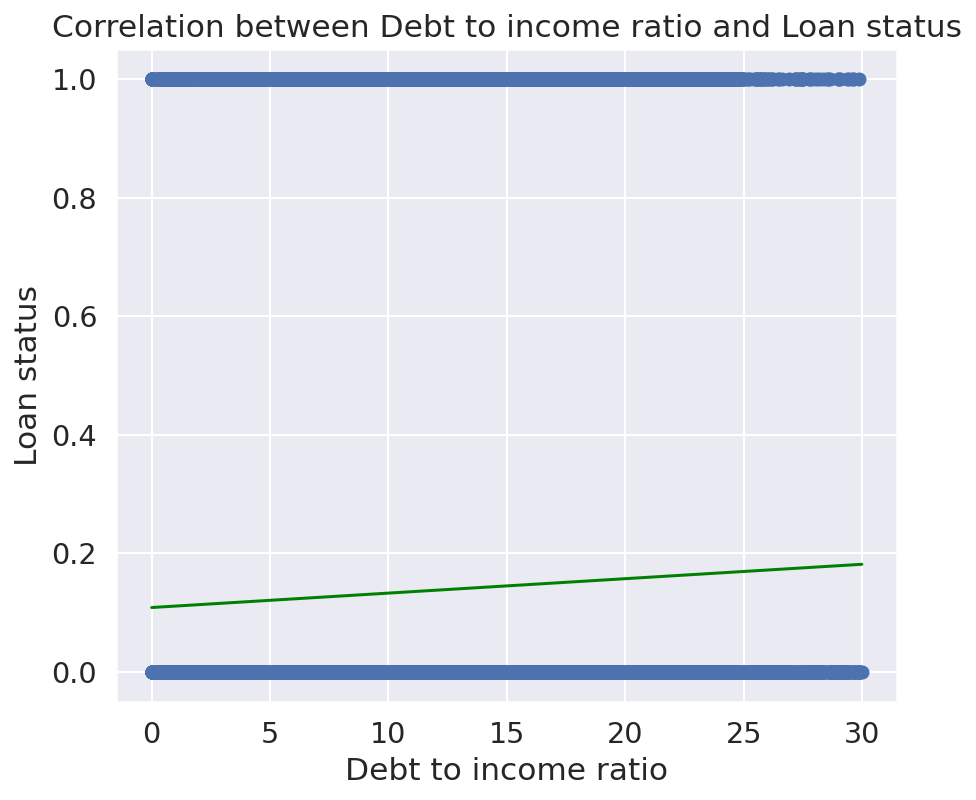

In [18]:
# Plot to identify the Debt to income ratio corelation with Loan status
var1 = OriginDataSet['dti']
var2 = OriginDataSet['loan_status_bit']
fig = plt.figure(figsize= (7,6))
plt.title ('Correlation between Debt to income ratio and Loan status')
plt.scatter (var1, var2)
plt.plot (np.unique(var1), np.poly1d(np.polyfit(var1, var2, 1))(np.unique(var1)), color = 'green')
plt.xlabel ('Debt to income ratio')
plt.ylabel ('Loan status')

Text(0, 0.5, 'Loan status')

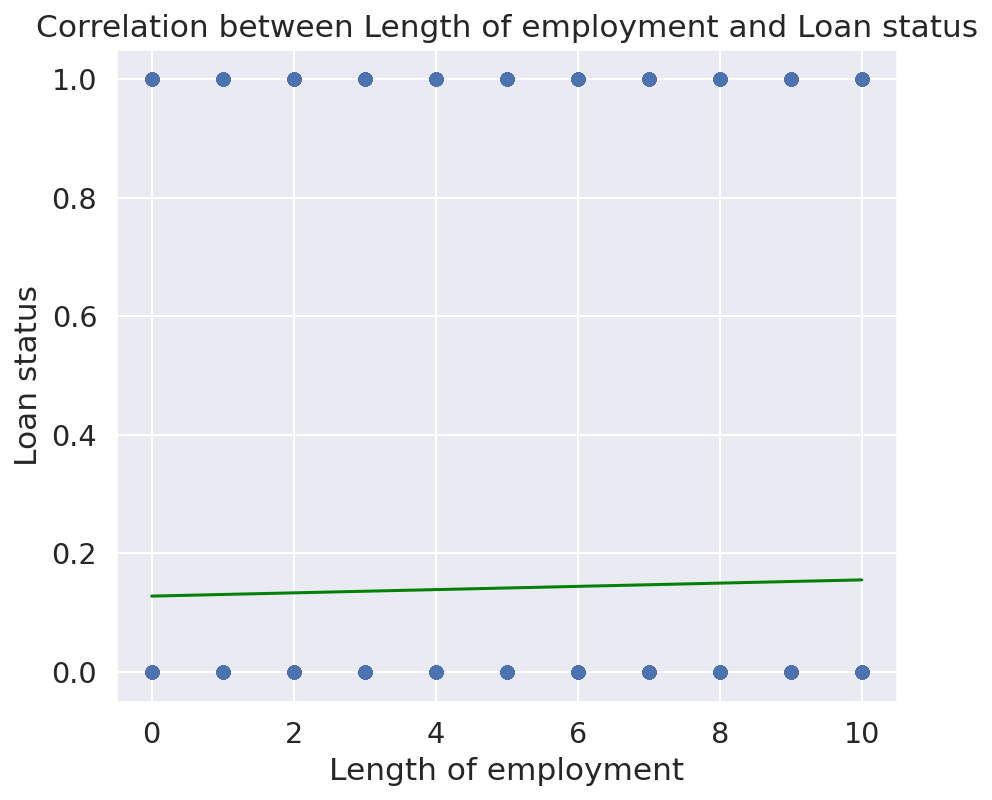

In [19]:
# Plot to identify the Length of employment corelation with Loan status
var1 = OriginDataSet['emp_length_num']
var2 = OriginDataSet['loan_status_bit']
fig = plt.figure(figsize= (7,6))
plt.title ('Correlation between Length of employment and Loan status')
plt.scatter (var1, var2)
plt.plot (np.unique(var1), np.poly1d(np.polyfit(var1, var2, 1))(np.unique(var1)), color = 'green')
plt.xlabel ('Length of employment')
plt.ylabel ('Loan status')

Text(0, 0.5, 'Loan status')

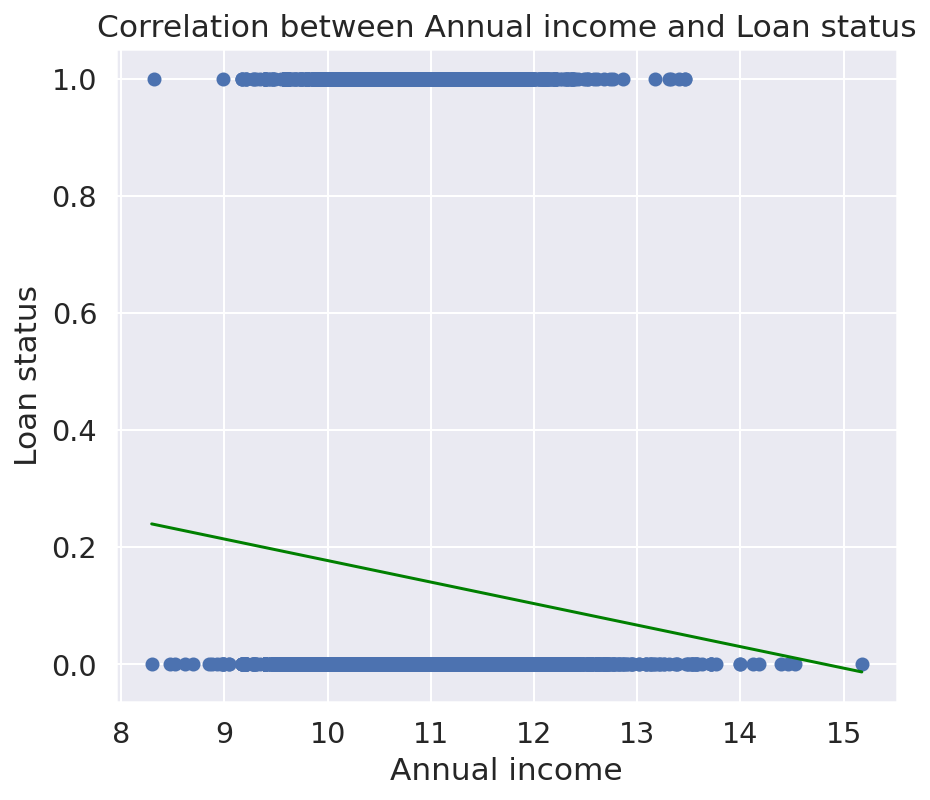

In [20]:
# Plot to identify the Annual income corelation with Loan status
var1 = OriginDataSet['annual_inc']
var2 = OriginDataSet['loan_status_bit']
fig = plt.figure(figsize= (7,6))
plt.title ('Correlation between Annual income and Loan status')
plt.scatter (var1, var2)
plt.plot (np.unique(var1), np.poly1d(np.polyfit(var1, var2, 1))(np.unique(var1)), color = 'green')
plt.xlabel ('Annual income')
plt.ylabel ('Loan status')

Text(0, 0.5, 'Loan status')

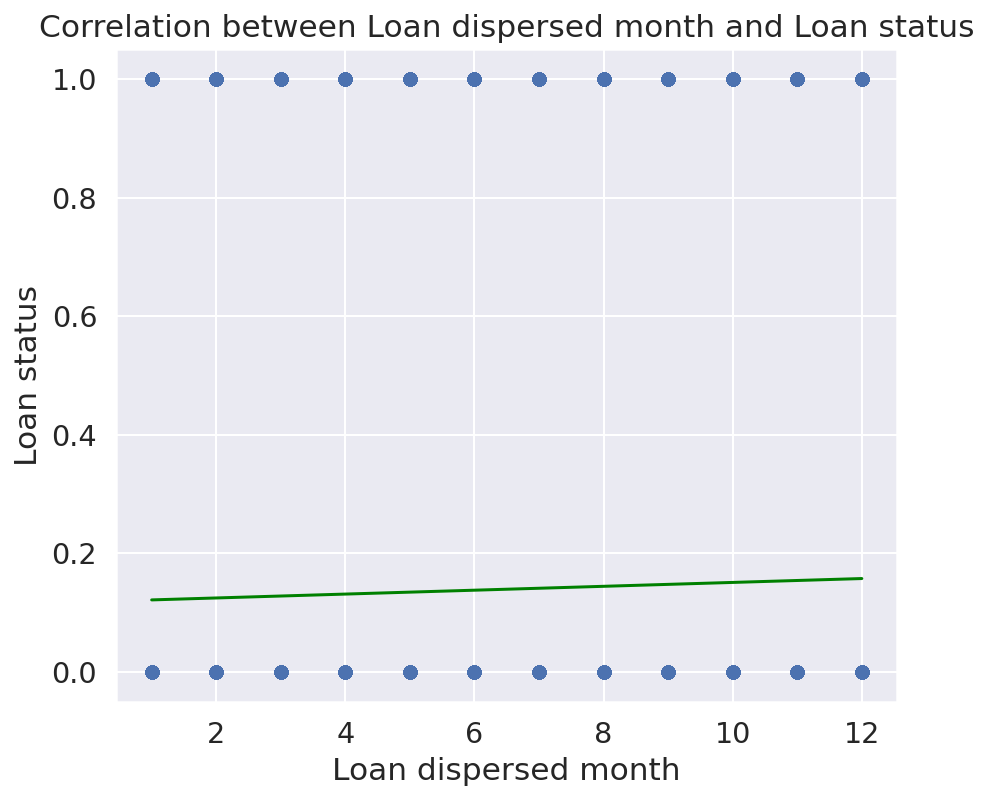

In [21]:

# Plot to identify the Loan dispersed month corelation with Loan status
var1 = OriginDataSet['issue_d']
var2 = OriginDataSet['loan_status_bit']
fig = plt.figure(figsize= (7,6))
plt.title ('Correlation between Loan dispersed month and Loan status')
plt.scatter (var1, var2)
plt.plot (np.unique(var1), np.poly1d(np.polyfit(var1, var2, 1))(np.unique(var1)), color = 'green')
plt.xlabel ('Loan dispersed month')
plt.ylabel ('Loan status')

Text(0, 0.5, 'Number of loans')

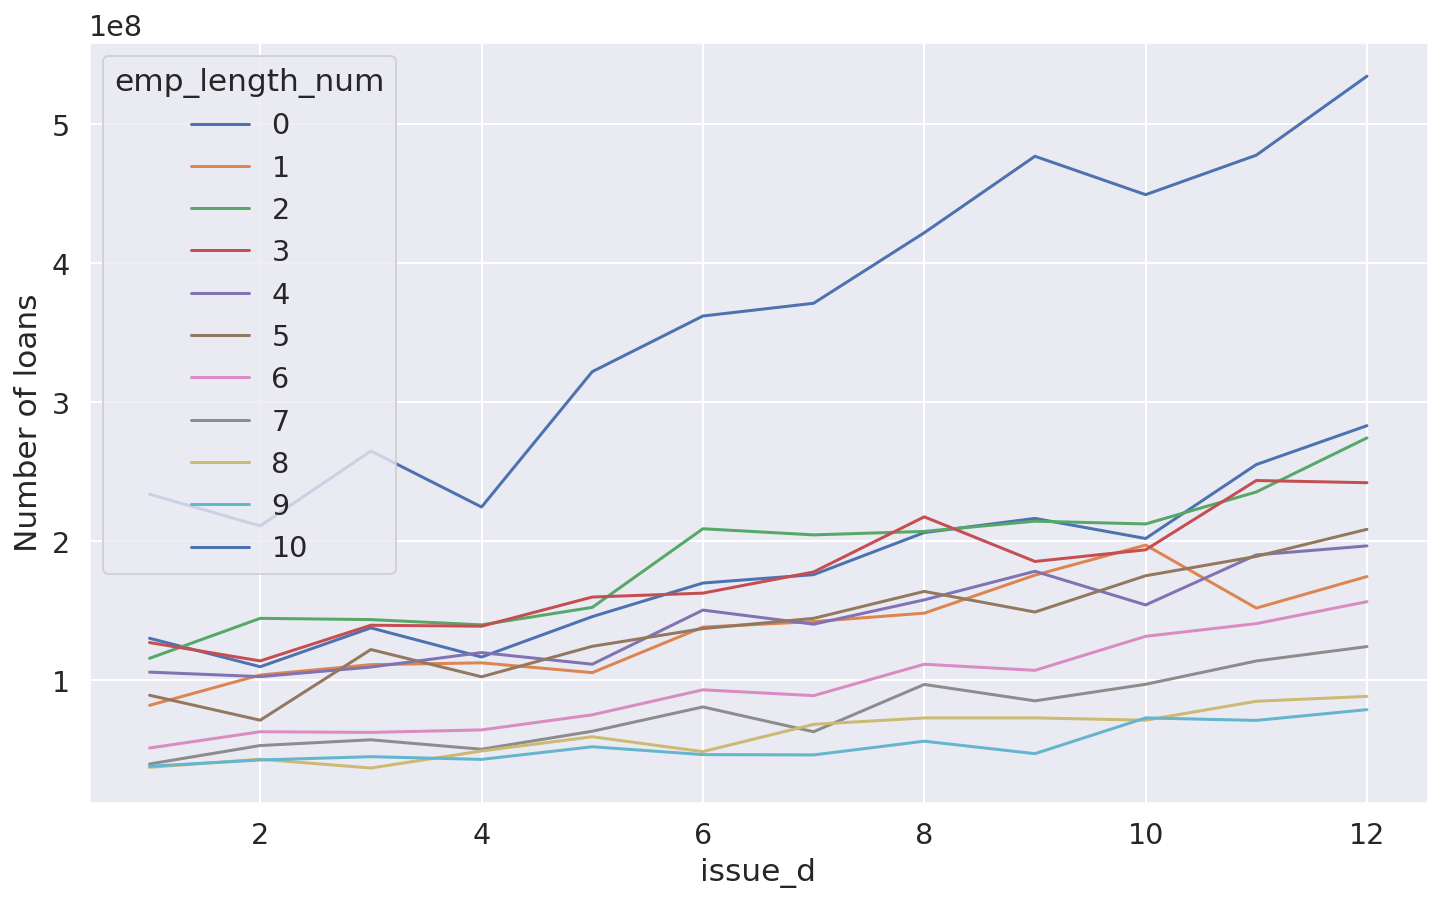

In [22]:
# number of loans distributed over the month and employment length
OriginDataSet.pivot_table('member_id',index ='issue_d',columns='emp_length_num',aggfunc='sum').plot()
plt.ylabel('Number of loans')

<span style='font-size:medium'>Corelation Matrix</span>


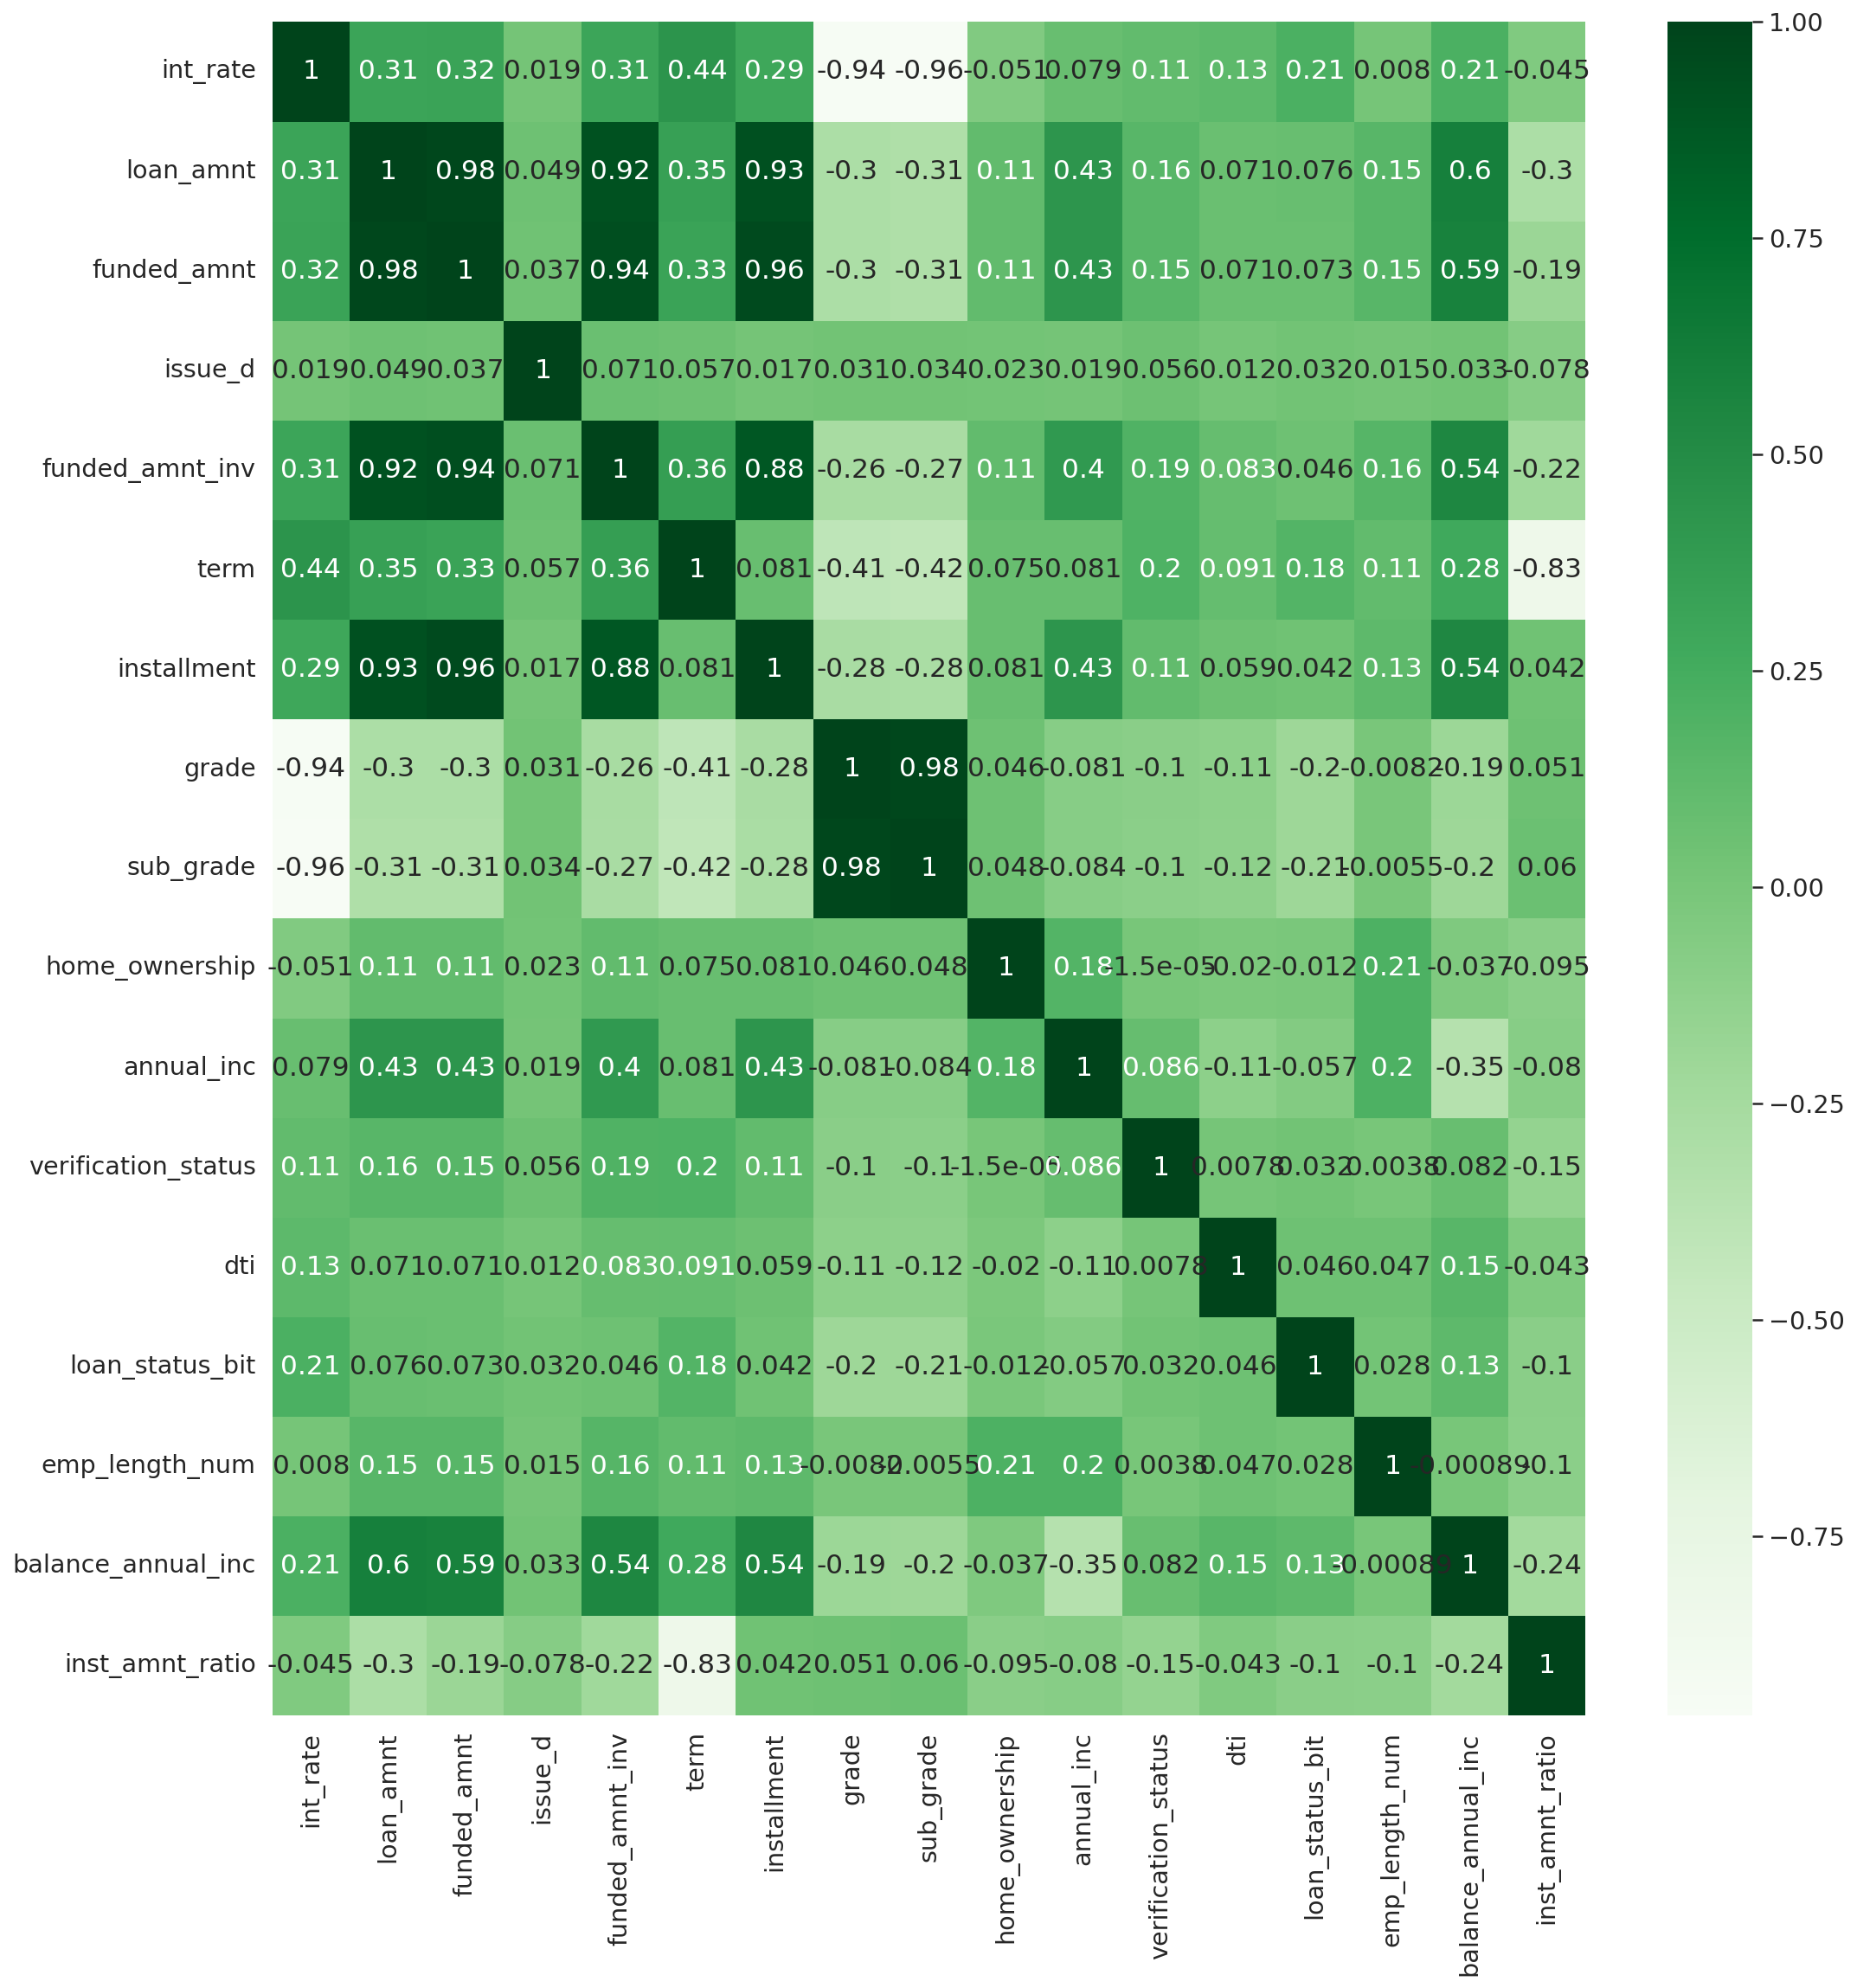

In [23]:
corr = OriginDataSet[num_cols].corr()
plt.figure(figsize=(17,18))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

In [24]:
Final_for_corelation = OriginDataSet[num_cols]
Final_for_corelation[Final_for_corelation.columns[1:]].corr()['loan_status_bit'][:-1]

loan_amnt              0.076499
funded_amnt            0.073149
issue_d                0.032325
funded_amnt_inv        0.046281
term                   0.176951
installment            0.042059
grade                 -0.203700
sub_grade             -0.206201
home_ownership        -0.011517
annual_inc            -0.057067
verification_status    0.031629
dti                    0.046339
loan_status_bit        1.000000
emp_length_num         0.027814
balance_annual_inc     0.127828
Name: loan_status_bit, dtype: float64

<span style='font-size:medium'>Based on the correlation values , the following variables have a positive correlation with the "loan\_status\_bit" feature:</span>

loan\_amnt: 0.076499

funded\_amnt: 0.073149

funded\_amnt\_inv: 0.046281

term: 0.176951

installment: 0.042059

issue\_d: 0.032325

verification\_status: 0.031629

dti: 0.046339

balance\_annual\_inc: 0.127828

The positive correlation coefficient suggests that as the value of these variables increases, the likelihood of loan default also increases.

On the other hand, the following variables have a negative correlation with the "loan\_status\_bit" feature:

grade: \-0.203700

sub\_grade: \-0.206201

annual\_inc: \-0.057067

home\_ownership: \-0.011517

emp\_length\_num: 0.027814

The negative correlation coefficient suggests that as the value of these variables decreases, the likelihood of loan default increases.

However, it is important to note that correlation does not necessarily imply causation, and other factors could be at play in determining the loan status.

